# Narupa Concepts: Frames


In this notebook, we'll dig into one of the main ideas in Narupa, the **frame**

In [1]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## What is a frame?

A frame is our way of representing a molecular system or trajectory in a way that is efficient to send over the network to clients, e.g. the VR app. 

The schematic illustrates this: a Narupa session produces a Frame Data object, which is serialized and transmitted using [GRPC](https://grpc.io) to client applications.

![Narupa Frame](images/frame_server.png)

A frame is represented as two dictionaries: one of arrays, and one of values. The arrays are used for sending lists of values of the same type, such as particle positions, while the values are used for transmitting single objects, such as numbers or strings.

Let's create a frame for a water molecule. We'll do it by hand.

### A Note on Narupa Units

In Narupa, we use the same units as our favourite MD package, [OpenMM](http://openmm.org/). 

| Quantity    | Unit              |
|-------------|-------------------|
| Distance    | nm                |
| Time        | ps                |
| mass        | atomic mass units |
| charge      | proton charge     |
| temperature | Kelvin            |
| angle       | radians           |
| energy      | kJ/mol            |

Why? Partially because we use OpenMM a lot, but also, to quote from [the OpenMM documentation](http://docs.openmm.org/latest/userguide/theory.html#units): 

> These units have the important feature that they form an internally consistent set. For example, a force always has the same units (kJ/mol/nm) whether it is calculated as the gradient of an energy or as the product of a mass and an acceleration. This is not true in some other widely used unit systems, such as those that express energy in kcal/mol.

So even though we interface with many packages, such as ASE, Sparrow and LAMMPS, which use different units, we always try to convert back to these units when producing frames.

In [3]:
import numpy as np

In [4]:
# arrange the water molecular O H H 
water_positions = np.array([[0,0,0],[0.075545, 0.047116, 0.00000], [-0.075545, 0.047116, 0.00000 ]])
# elements are defined by their atomic numbers
water_elements = [8, 1, 1]
# Define bonds between the oxygen and the hydrogens.
water_bonds = np.array([[0, 1], [0, 2]])

<IPython.core.display.Javascript object>


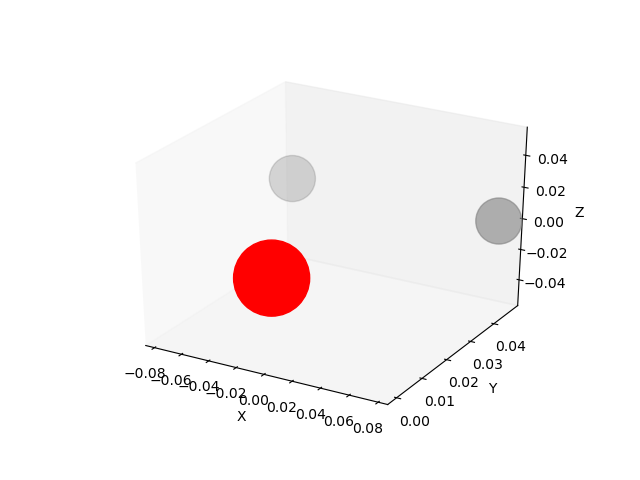

Text(0.5, 0, 'Z')

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(water_positions[:,0], water_positions[:,1], water_positions[:,2], c=['red','gray','gray'], s=[3000, 1100, 1100])
ax.grid(b=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


Now, we create an empty frame and put all of this data in by accessing the appropriate storage (arrays or values) and assigning a key.

In [6]:
from narupa.trajectory import FrameData

In [7]:
frame = FrameData()

In [8]:
frame.arrays['particle.positions'] = water_positions.flatten() # We have to store as a flat array.
frame.arrays['particle.elements'] = water_elements
frame.arrays['bond.pairs'] = water_bonds.flatten()

In [9]:
frame.values['particle.count'] = 3

Let's print out the frame, how this looks when communicated to clients. It's just two dictionaries, one with values, one with arrays.

In [10]:
frame.raw

values {
  key: "particle.count"
  value {
    number_value: 3.0
  }
}
arrays {
  key: "bond.pairs"
  value {
    index_values {
      values: 0
      values: 1
      values: 0
      values: 2
    }
  }
}
arrays {
  key: "particle.elements"
  value {
    index_values {
      values: 8
      values: 1
      values: 1
    }
  }
}
arrays {
  key: "particle.positions"
  value {
    float_values {
      values: 0.0
      values: 0.0
      values: 0.0
      values: 0.07554499804973602
      values: 0.0471160002052784
      values: 0.0
      values: -0.07554499804973602
      values: 0.0471160002052784
      values: 0.0
    }
  }
}

To make things easier to use, the python wrapper has shortcuts for common molecular properties:

In [11]:
frame.shortcuts

{'bond_orders',
 'bond_pairs',
 'box_vectors',
 'chain_count',
 'chain_names',
 'kinetic_energy',
 'particle_count',
 'particle_elements',
 'particle_names',
 'particle_positions',
 'particle_residues',
 'particle_types',
 'potential_energy',
 'residue_chains',
 'residue_count',
 'residue_ids',
 'residue_names'}

So we can see what keys have been set: 

In [12]:
frame.array_keys

{'bond.pairs', 'particle.elements', 'particle.positions'}

In [13]:
frame.value_keys

{'particle.count'}

And we could have used the shortcuts to get and set the fields:

In [14]:
frame.particle_count = 3
frame.particle_positions = water_positions
frame.particle_elements = water_elements
frame.bond_pairs = water_bonds

In [15]:
frame.particle_positions

[[0.0, 0.0, 0.0],
 [0.07554499804973602, 0.0471160002052784, 0.0],
 [-0.07554499804973602, 0.0471160002052784, 0.0]]

We can also see what shortcuts are linked to some data in the frame:

In [16]:
frame.used_shortcuts

{'bond_pairs', 'particle_count', 'particle_elements', 'particle_positions'}

## Transmit it to VR

We've provided enough data to visualize this amazing molecule in VR. So we'll fire up a server and send this frame.

In [17]:
from narupa.app import NarupaFrameApplication

In [18]:
server = NarupaFrameApplication.basic_server(port=0)

In [19]:
server.frame_publisher.send_frame(0, frame)

Connect from VR, and you'll see something like this:

![Narupa H2O](images/h2o.png)

## What kind of data can I send?

You may have noticed that the particle count was transmitted as a `number_value` in the frame, and that the positions were a `float_value`. What kind of values can you send? What kind of arrays can you send? 

### Arrays

For the arrays, you can send decimal number (floats), positive integers (unsigned int) and strings. The types are restricted so we can send them efficiently.

In [20]:
frame.arrays['some floats'] = [1.0, 2.5, 3.5]
frame.arrays['some numbers'] = [1,2,3]
frame.arrays['some strings'] = ['a', 'bc', 'de']

Of course, an array could just be an array of bytes (those in the business call these a `blob`)

In [21]:
with open('images/example_image.jpg', 'rb') as f:
    image_bytes = f.read()

In [22]:
frame.arrays['image'] = image_bytes

In [23]:
server.frame_publisher.send_frame(0, frame)

In [24]:
from narupa.app import NarupaImdClient
from IPython.display import Image

with NarupaImdClient.connect_to_single_server(port=server.port) as client:
    client.wait_until_first_frame()
    received_image_bytes = bytes(client.latest_frame.arrays['image'])

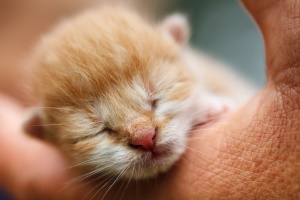

In [25]:
Image(data=received_image_bytes, width=200)

### Values

For setting values, you can send any of a boolean, string or number:

In [26]:
frame.values['boolean'] = False
frame.values['string'] = 'hello'
frame.values['a number'] = 1.0

**Note**: The underlying structure will support anything that can be represented with Protobuf's [Value](https://developers.google.com/protocol-buffers/docs/reference/csharp/class/google/protobuf/well-known-types/value) type - this will be fixed in an upcoming release. 

## More Molecular Data 

As well as the positions, bonds, and elements, we can set additional fields that are commonly available in topological fields formats. If these are passed, lots of exciting rendering and selection opportunites present themselves.

The following assigns the water molecule to the residue HOH, in the chain A.

In [26]:
frame.residue_ids = ['1', '1', '1']
frame.residue_names = ['HOH', 'HOH', 'HOH']
frame.residue_count = 1
frame.particle_residues = [0,0,0]
frame.chain_names = ['A']
frame.chain_count = 1
frame.residue_chains = [0]

In [27]:
server.frame_publisher.send_frame(0, frame)

## Updating Data in a Frame

When sending data, the iMD-VR client is intelligent enough to reuse data it has received before, so you don't need to send the everything every time. 

Our convention is to send the topology in the first frame, then just positions after that. The Frame server is smart enough to send the latest version of everything to a client when it first connects.

In the following, we just update the positions array to move the water molecule by 1 nanometer in each cardinal direction.

In [28]:
positions_frame = FrameData()
positions_frame.particle_positions = water_positions + 1

In [29]:
server.frame_publisher.send_frame(1, positions_frame)

# Next Steps

* See more practical examples of setting up [simulations](../ase/basic_example.ipynb) and [trajectories](../mdanalysis/mdanalysis_trajectory.ipynb)
* Learn how to set up [commands and synchronise state](commands_and_state.ipynb)
* Learn about the details of setting up [servers](servers.ipynb)